# Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from PIL import Image
from skimage.color import rgba2rgb
import cv2
from IPython.display import display, clear_output
from math import *
import time

from os import makedirs, path

from tqdm import tqdm

# Define Classes/Functions

In [2]:
HIDDEN = 32
DIM = 16
RES = 128


def augment(x):
    xx = x + 0.4*torch.randn_like(x) + 0.2*torch.randn(x.size(0)).cuda().view(x.size(0),1,1,1)
    xx = xx*(2*torch.randint(2,(x.size(0),)).float().cuda().view(x.size(0),1,1,1)-1)
    xx = xx[:,:,8:-8,8:-8]
    
    return xx


def totalistic(x):
    z = 0.125 * (x + x.flip(2) + x.flip(3) + x.flip(2).flip(3))
    z = z + 0.125 * (x.transpose(2, 3) + x.transpose(2, 3).flip(2) + x.transpose(2, 3).flip(3) + x.transpose(2, 3).flip(
        2).flip(3))
    z = z - z.mean(3).mean(2).unsqueeze(2).unsqueeze(3)

    return z


class Rule(nn.Module):
    def __init__(self):
        super().__init__()
        self.filter1 = nn.Parameter(torch.randn(HIDDEN, 1, 5, 5)/sqrt(HIDDEN))
        self.bias1 = nn.Parameter(0*torch.randn(HIDDEN))

        self.filter2 = nn.Conv2d(HIDDEN, HIDDEN, 1, padding=0)
        nn.init.orthogonal_(self.filter2.weight, gain=2)
        nn.init.zeros_(self.filter2.bias)
        self.filter3 = nn.Conv2d(HIDDEN, HIDDEN, 1, padding=0)
        nn.init.orthogonal_(self.filter3.weight, gain=2)
        nn.init.zeros_(self.filter3.bias)


class CA(nn.Module):
    def __init__(self):
        super().__init__()

        self.rule = Rule()
        self.optim = torch.optim.Adam(self.parameters(), lr=1e-3)

    def initGrid(self, BS):
        self.psi = torch.cuda.FloatTensor(2 * np.random.rand(BS, HIDDEN, RES, RES) - 1)

    def forward(self):
        z = F.conv2d(self.psi, weight=totalistic(self.rule.filter1), bias=self.rule.bias1, padding=2, groups=HIDDEN)
        z = F.leaky_relu(z)
        z = F.leaky_relu(self.rule.filter2(z))
        self.psi = torch.tanh(self.psi + self.rule.filter3(z))

    def cleanup(self):
        del self.psi


class Embedder(nn.Module):
    def __init__(self):
        super().__init__()

        self.c1 = nn.Conv2d(3, 32, 3, padding=1)
        nn.init.orthogonal_(self.c1.weight, gain=sqrt(2))
        self.p1 = nn.AvgPool2d(2)
        self.c2 = nn.Conv2d(32, 64, 3, padding=1)
        nn.init.orthogonal_(self.c2.weight, gain=sqrt(2))
        self.p2 = nn.AvgPool2d(2)
        self.c3 = nn.Conv2d(64, 128, 3, padding=1)
        nn.init.orthogonal_(self.c3.weight, gain=sqrt(2))
        self.p3 = nn.AvgPool2d(2)
        self.c4 = nn.Conv2d(128, 128, 3, padding=1)
        nn.init.orthogonal_(self.c4.weight, gain=sqrt(2))
        self.p4 = nn.AvgPool2d(2)
        self.c5 = nn.Conv2d(128, DIM, 3, padding=1)

    def forward(self, x):
        z = self.p1(F.leaky_relu(self.c1(x)))
        z = self.p2(F.leaky_relu(self.c2(z)))
        z = self.p3(F.leaky_relu(self.c3(z)))
        z = self.p4(F.leaky_relu(self.c4(z)))
        z = self.c5(z).mean(3).mean(2)

        z = z/torch.sqrt(1+torch.sum(z**2,1).unsqueeze(1))

        return z


def findHardNegative(zs):
    step = 0

    while step < 1000:
        i = np.random.randint(zs.shape[0])
        j = i
        k = np.random.randint(zs.shape[0] - 1)
        if k >= i:
            k += 1

        i2 = np.random.randint(zs.shape[1])
        j2 = np.random.randint(zs.shape[1] - 1)
        if j2 >= i2:
            j2 += 1
        k2 = np.random.randint(zs.shape[1])

        z1 = zs[i, i2]
        z2 = zs[j, j2]
        z3 = zs[k, k2]

        delta = np.sqrt(np.sum((z1 - z2) ** 2, axis=0)) - np.sqrt(np.sum((z1 - z3) ** 2, axis=0)) + 1
        if delta >= 0.9:
            break
        step += 1

    return i, k, step

# Test

In [7]:
population = [CA().cuda() for i in range(1)]
for ca in population:
    ca.initGrid(BS=1)
# embed = Embedder().cuda()

450


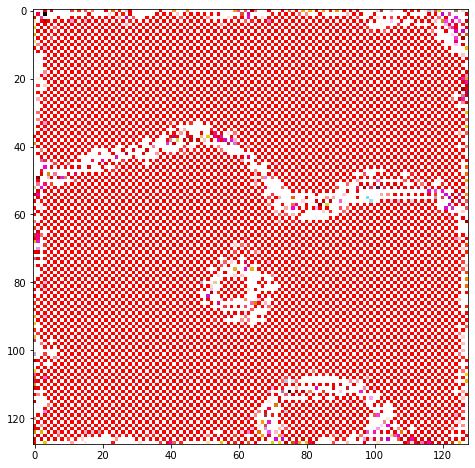

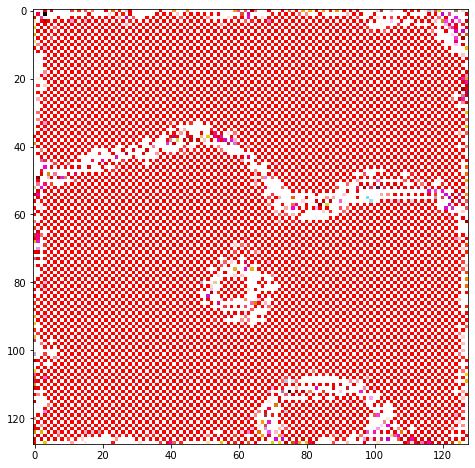

In [9]:
CA_run = population[0]
CA_run.initGrid(BS=1)

# CENTER SEED
x = torch.cuda.FloatTensor(np.zeros((HIDDEN, RES, RES))).unsqueeze(0)
x[:, 3:, RES//2, RES//2] = 1
# x[:, 3:, RES//3 : 2*RES//3, RES//3 : 2*RES//3] = 1
CA_run.psi = x

imgs = []

timeSteps = 500

with torch.no_grad():
    for i in range(timeSteps):
        nx = CA_run.psi.cpu().numpy()[0, 0:4, :, :].transpose(1, 2, 0)
        nx = rgba2rgb(nx)
        imgs.append(nx)

        if i%50 == 0:
            plt.clf()
            plt.imshow(nx)
            plt.gcf().set_size_inches((8,8))
            clear_output(wait=True)
            print(f'{i}')
            display(plt.gcf())
            time.sleep(0.01)

        CA_run.forward()
    

fname = time.strftime("%Y%m%d-%H%M%S")
out = cv2.VideoWriter(f'CA-{fname}.avi',cv2.VideoWriter_fourcc(*'DIVX'), 60, (RES, RES), 3)

for img in imgs:
    img = np.uint8(cv2.cvtColor(img, cv2.COLOR_RGB2BGR)*255.0)
    out.write(img)
out.release()

# Train

In [ ]:
population = [CA().cuda() for i in range(100)]
timestr = time.strftime("%Y%m%d-%H%M%S")

'''
for i in range(1,len(population)):
    population[i].rule.filter1.data = population[0].rule.filter1.data.detach()
    population[i].rule.bias1.data = population[0].rule.bias1.data.detach()
    population[i].rule.filter2.weight.data = population[0].rule.filter2.weight.data.detach()
    population[i].rule.filter3.weight.data = population[0].rule.filter3.weight.data.detach()
    population[i].rule.filter2.bias.data = population[0].rule.filter2.bias.data.detach()
    population[i].rule.filter3.bias.data = population[0].rule.filter3.bias.data.detach()
'''

embed = Embedder().cuda()

emb_err = []
ca_err = []
hard_frac = []

e_optim = torch.optim.Adam(embed.parameters(), lr=1e-4)
tloss = nn.TripletMarginLoss()

CBS = 10 # should be even number
# EBS = 15
# ESTEPS = 25
EBS = 5
ESTEPS = 50

for epoch in range(100):
    print(f'Epoch: {epoch}')
    e_loss = []
    c_loss = []
    h_loss = []

    zs = []
    xs = []
    with torch.no_grad():
        print('Generating embeddings for CAs...')
        for ca in population:
            lzs = []
            ca.initGrid(CBS)
            for j in range(25):
                ca.forward()
                
            x = []
            for j in range(3):
                x.append(ca.psi[:,0:1,:,:])
                ca.forward()
            x = torch.cat(x,1)
            
            lzs.append(embed.forward(x).cpu().detach().numpy())
            # lxs.append(ca.psi.cpu().detach().numpy())
            zs.append(np.concatenate(lzs, axis=0)[np.newaxis])
            ca.cleanup()
        zs = np.concatenate(zs, axis=0)

    # Train embedder
    print('Training embedder')
    for i in range(ESTEPS):
        x1 = []
        x2 = []
        x3 = []

        for j in range(EBS):
            a, b, hard = findHardNegative(zs)

            CA1 = population[a]
            CA2 = population[b]

            with torch.no_grad():
                CA1.initGrid(2)
                CA2.initGrid(1)

                K1 = 25
                K2 = 25

                for k in range(K1):
                    CA1.forward()
                    
                c1 = []
                for k in range(3):
                    c1.append(CA1.psi[:,0:1,:,:])
                    CA1.forward()
                c1 = torch.cat(c1,1)
                
                for k in range(K2):
                    CA2.forward()

                c2 = []
                for k in range(3):
                    c2.append(CA2.psi[:,0:1,:,:])
                    CA2.forward()
                c2 = torch.cat(c2,1)
                
                # is there a reason we're throwing these into CPU and then throwing them back on GPU later? 
                im1 = c1[0].cpu().detach().numpy()
                im2 = c1[1].cpu().detach().numpy()
                im3 = c2[0].cpu().detach().numpy()

                CA1.cleanup()
                CA2.cleanup()

            x1.append(im1)
            x2.append(im2)
            x3.append(im3)
            h_loss.append(hard)

        x1 = torch.cuda.FloatTensor(np.array(x1))
        x2 = torch.cuda.FloatTensor(np.array(x2))
        x3 = torch.cuda.FloatTensor(np.array(x3))

        e_optim.zero_grad()
        z1 = embed.forward(x1)
        z2 = embed.forward(x2)
        z3 = embed.forward(x3)

        loss = tloss(z1, z2, z3)
        loss.backward()
        e_optim.step()

        e_loss.append(loss.cpu().detach().item())

    emb_err.append(np.mean(e_loss))
    hard_frac.append(np.mean(h_loss))
    print(f'emb_err: {emb_err[-1]}, hard_frac: {hard_frac[-1]}')

    # Train CAs
    print('Training CAs')
    for ii in range(len(population) // 2):
        i = np.random.randint(len(population))
        CA1 = population[i]
        z1 = zs[i, 0]
        z2 = zs[i, 1]

        d12 = np.sqrt(np.sum((z1 - z2) ** 2, axis=0))
        step = 0
        while step < 1000:
            j = np.random.randint(len(population) - 1)
            if j >= i:
                j += 1

            z3 = zs[j, 0]

            d13 = np.sqrt(np.sum((z1 - z3) ** 2, axis=0))
            if d12 - d13 + 1 > 1:
                break

            step += 1

        CA2 = population[j]

        CA1.optim.zero_grad()
        CA2.optim.zero_grad()

        CA1.initGrid(CBS)
        CA2.initGrid(CBS//2)

        S1 = 25
        S2 = 25

        for j in range(S1):
            CA1.forward()
            
        c1 = []
        for k in range(3):
            c1.append(CA1.psi[:,0:1,:,:])
            CA1.forward()
        c1 = torch.cat(c1,1)

        for j in range(S2):
            CA2.forward()
            
        c2 = []
        for k in range(3):
            c2.append(CA2.psi[:,0:1,:,:])
            CA2.forward()
        c2 = torch.cat(c2,1)

#         im = CA1.psi.detach().cpu().numpy()[0, 0, :, :] * 0.5 + 0.5
#         im = (255 * np.clip(im, 0, 1)).astype(np.uint8)
        im = CA1.psi.detach().cpu().numpy()[0, 0:3, :, :].transpose(1, 2, 0) * 0.5 + 0.5
        im = (im * 255).astype('uint8')
        im = Image.fromarray(im, 'RGB')
        
#         fpath = path.join('frames', timestr, 'epoch_' + str(epoch).zfill(3))
        fpath = path.join('frames', timestr, 'CA', 'CA_' + str(i).zfill(5)) # images saved according to CA
        fpath_epoch = path.join('frames', timestr, 'all', 'epoch_' + str(epoch).zfill(3)) # images saved according to epoch
        if not path.exists(fpath):
            makedirs(fpath)
        if not path.exists(fpath_epoch):
            makedirs(fpath_epoch)
        im.save(path.join(fpath, str(i).zfill(5) + '_epoch_' + str(epoch).zfill(3) + '.png'))
        im.save(path.join(fpath_epoch, 'CA_' + str(i).zfill(5) + '.png'))
        
        z1 = embed.forward(c1)
        z3 = embed.forward(c2)

        z2 = z1[CBS//2:]
        z1 = z1[:CBS//2]

        loss = tloss(z1,z2,z3)
        loss.backward()
        CA1.optim.step()
        CA2.optim.step()

        c_loss.append(loss.cpu().detach().item())

        CA1.cleanup()
        CA2.cleanup()

    ca_err.append(np.mean(c_loss))
    print(f'CA_loss: {ca_err[-1]}')

    np.savetxt("embed.txt", np.array(emb_err))
    np.savetxt("ca.txt", np.array(ca_err))
    np.savetxt("hard.txt", np.array(hard_frac))


Epoch: 0
Generating embeddings for CAs...
Training embedder
emb_err: 0.8008884108066558, hard_frac: 8.416
Training CAs
CA_loss: 0.32186299055814743
Epoch: 1
Generating embeddings for CAs...
Training embedder
emb_err: 0.7984526717662811, hard_frac: 20.656
Training CAs
CA_loss: 0.27670101071707903
Epoch: 2
Generating embeddings for CAs...
Training embedder
emb_err: 0.8576934415102005, hard_frac: 27.124
Training CAs
CA_loss: 0.30965398092754187
Epoch: 3
Generating embeddings for CAs...
Training embedder
emb_err: 0.8017930090427399, hard_frac: 36.404
Training CAs
CA_loss: 0.2697276452637743
Epoch: 4
Generating embeddings for CAs...
Training embedder
emb_err: 0.8453471285104751, hard_frac: 25.172
Training CAs
CA_loss: 0.3526860271953046
Epoch: 5
Generating embeddings for CAs...
Training embedder
emb_err: 0.860453007221222, hard_frac: 24.632
Training CAs
CA_loss: 0.25723031397908924
Epoch: 6
Generating embeddings for CAs...
Training embedder
emb_err: 0.8785305190086364, hard_frac: 25.04
Trai

In [ ]:
# Random Debug

In [ ]:
im1 = CA1.psi.cpu().detach().numpy()[0, 0:3, :, :].transpose(1, 2, 0)
im2 = CA1.psi.cpu().detach().numpy()[1, 0:3, :, :].transpose(1, 2, 0)
plt.imshow(np.abs(im2-im1)/2)

In [ ]:
plt.imshow((CA2.psi.cpu().detach().numpy()[0, 0:3, :, :].transpose(1, 2, 0) + 1)/2)

In [ ]:
plt.imshow(embed.forward(CA1.psi).cpu().detach().numpy()[0, 0:3, :, :].transpose(1, 2, 0))

In [ ]:
np.shape(lzs)

In [ ]:
embed.forward(population[0].psi).mean(3).mean(2).cpu().detach().numpy().shape

In [ ]:
plt.plot(embed.forward(CA1.psi).mean(3).mean(2).cpu().detach().numpy().transpose())

In [ ]:
embed.forward(population[0].psi).cpu().detach().numpy().shape

In [ ]:
zs.shape

In [120]:
zs.shape